/var/folders/6_/mffrf4kj2bj6f4bf8rf7s4zc0000gn/T/ipykernel_41865/1541465150.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range("2023-01-01", periods=n_points, freq='H'),


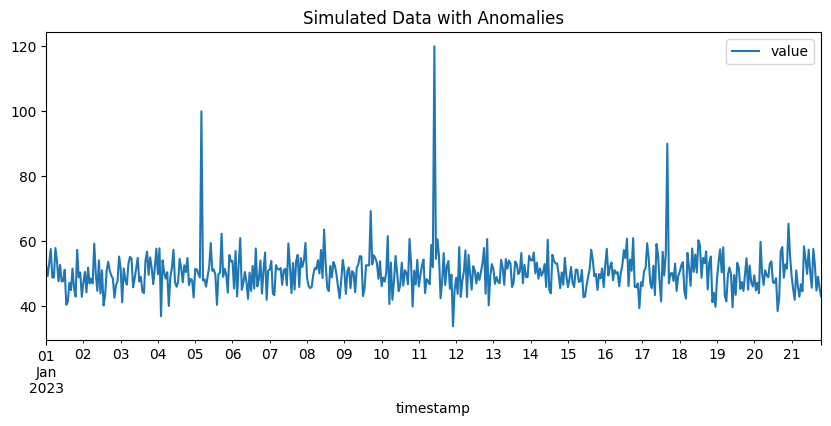

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n_points = 500
data = np.random.normal(loc=50, scale=5, size=n_points)

data[100] = 100
data[250] = 120
data[400] = 90

df = pd.DataFrame({
    'timestamp': pd.date_range("2023-01-01", periods=n_points, freq='H'),
    'value': data
})

df.plot(x='timestamp', y='value', title="Simulated Data with Anomalies", figsize=(10, 4))
plt.show()

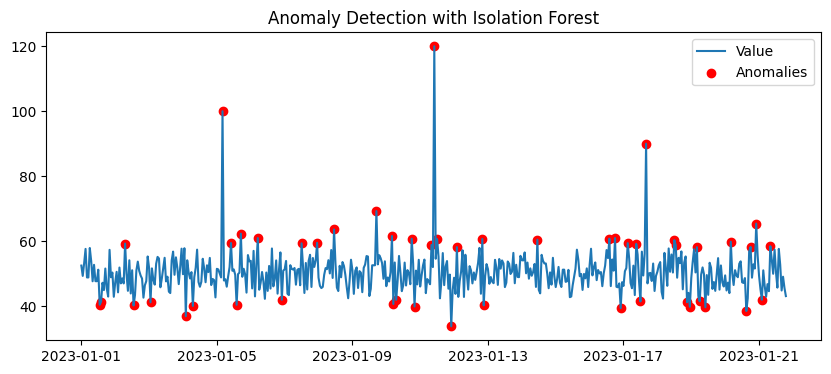

In [2]:
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df[['value']].values
X_scaled = scaler.fit_transform(X)

clf = IForest()
clf.fit(X_scaled)
df['anomaly'] = clf.predict(X_scaled) 

plt.figure(figsize=(10, 4))
plt.plot(df['timestamp'], df['value'], label="Value")
plt.scatter(df[df['anomaly'] == 1]['timestamp'], df[df['anomaly'] == 1]['value'], color='red', label="Anomalies")
plt.legend()
plt.title("Anomaly Detection with Isolation Forest")
plt.show()


In [3]:
def suggest_actions(row):
    if row['anomaly'] == 1:
        return "Check pipeline: possible value drift or injection"
    return "Normal"

df['action'] = df.apply(suggest_actions, axis=1)
df[['timestamp', 'value', 'anomaly', 'action']].tail(10)


,timestamp,value,anomaly,action
490,2023-01-21 10:00:00,49.960137,0,Normal
491,2023-01-21 11:00:00,57.399721,0,Normal
492,2023-01-21 12:00:00,50.386842,0,Normal
493,2023-01-21 13:00:00,45.693579,0,Normal
494,2023-01-21 14:00:00,57.615620,0,Normal
495,2023-01-21 15:00:00,52.694550,0,Normal
496,2023-01-21 16:00:00,44.813769,0,Normal
497,2023-01-21 17:00:00,49.048307,0,Normal
498,2023-01-21 18:00:00,45.621909,0,Normal
499,2023-01-21 19:00:00,43.086001,0,Normal


In [4]:
from prefect import flow, task

@task
def load_data():
    return df

@task
def detect_anomalies(data):
    return data[data['anomaly'] == 1]

@task
def take_actions(anomalies):
    print("Anomalies detected:", len(anomalies))
    if not anomalies.empty:
        print("⚠️  Action required on pipeline due to anomalies")
    else:
        print("✅ No action needed")

@flow
def anomaly_pipeline():
    data = load_data()
    anomalies = detect_anomalies(data)
    take_actions(anomalies)

anomaly_pipeline()

14:53:23.647 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8644
See https://docs.prefect.io/3.0/manage/self-host#self-host-a-prefect-server for more information on running a dedicated Prefect server.

14:53:24.870 | INFO    | Flow run 'tangerine-sidewinder' - Beginning flow run 'tangerine-sidewinder' for flow 'anomaly-pipeline'

14:53:24.891 | INFO    | Task run 'load_data-ac8' - Finished in state Completed()

14:53:24.908 | INFO    | Task run 'detect_anomalies-121' - Finished in state Completed()

Anomalies detected: 50
⚠️  Action required on pipeline due to anomalies


14:53:24.923 | INFO    | Task run 'take_actions-923' - Finished in state Completed()

14:53:24.935 | INFO    | Flow run 'tangerine-sidewinder' - Finished in state Completed()

In [5]:
df.to_csv("anomaly_data.csv", index=False)